In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import vit_b_16, ViT_B_16_Weights
from tqdm import tqdm

# Data Loading and Preprocessing
def load_all_folds(base_path):
    folds = ["Fold 1", "Fold 2", "Fold 3"]
    all_images, all_masks, all_types = [], [], []
    
    for fold in folds:
        fold_path = os.path.join(base_path, fold)
        images = np.load(os.path.join(fold_path, "images", f"fold{fold[-1]}", "images.npy"))
        masks = np.load(os.path.join(fold_path, "masks", f"fold{fold[-1]}", "masks.npy"))
        types = np.load(os.path.join(fold_path, "images", f"fold{fold[-1]}", "types.npy"))
        
        all_images.append(images)
        all_masks.append(masks)
        all_types.append(types)
    
    return all_images, all_masks, all_types

base_path = "/rsrch5/home/plm/yshokrollahi/vitamin-p/vitamin-p/data/raw/H&E"
all_images, all_masks, all_types = load_all_folds(base_path)

def create_train_val_test_split(all_images, all_masks, all_types):
    splits = []
    
    for test_fold in range(3):
        train_val_folds = [i for i in range(3) if i != test_fold]
        
        train_val_images = np.concatenate([all_images[i] for i in train_val_folds])
        train_val_masks = np.concatenate([all_masks[i] for i in train_val_folds])
        train_val_types = np.concatenate([all_types[i] for i in train_val_folds])
        
        num_samples = len(train_val_images)
        num_val = num_samples // 10
        
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        
        val_indices = indices[:num_val]
        train_indices = indices[num_val:]
        
        split = {
            'train': {
                'images': train_val_images[train_indices],
                'masks': train_val_masks[train_indices],
                'types': train_val_types[train_indices]
            },
            'val': {
                'images': train_val_images[val_indices],
                'masks': train_val_masks[val_indices],
                'types': train_val_types[val_indices]
            },
            'test': {
                'images': all_images[test_fold],
                'masks': all_masks[test_fold],
                'types': all_types[test_fold]
            }
        }
        
        splits.append(split)
    
    return splits

data_splits = create_train_val_test_split(all_images, all_masks, all_types)
print("done")


/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


done


In [2]:
import torch
import numpy as np
import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import functional as TF
from scipy.ndimage import gaussian_filter, map_coordinates
from skimage.segmentation import slic

class CellSegmentationDataset(Dataset):
    def __init__(self, images, masks, image_transform=None, mask_transform=None, augment=False):
        self.images = images
        self.masks = masks
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.augment = augment

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        # Normalize image to 0-1 range and convert to float32
        image = ((image - image.min()) / (image.max() - image.min())).astype(np.float32)
        
        # Create binary mask from the last channel and convert to float32
        binary_mask = (mask[..., 5] > 0).astype(np.float32)

        if self.augment:
            image, binary_mask = self.apply_augmentation(image, binary_mask)

        if self.image_transform:
            image = self.image_transform(image)

        if self.mask_transform:
            binary_mask = self.mask_transform(binary_mask)

        return image, binary_mask

    def apply_augmentation(self, image, mask):
        # Convert numpy arrays to tensors
        image = torch.from_numpy(image).permute(2, 0, 1)
        mask = torch.from_numpy(mask).unsqueeze(0)

        original_size = image.shape[1:]

        # Random 90-degree rotation
        if torch.rand(1) < 0.5:
            k = torch.randint(1, 4, (1,)).item()
            image = torch.rot90(image, k, [1, 2])
            mask = torch.rot90(mask, k, [1, 2])

        # Random horizontal flip
        if torch.rand(1) < 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Random vertical flip
        if torch.rand(1) < 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)

        # Random scaling (downscaling)
        if torch.rand(1) < 0.5:
            scale_factor = torch.FloatTensor(1).uniform_(0.8, 1.0).item()
            new_size = [max(224, int(s * scale_factor)) for s in image.shape[1:]]
            image = TF.resize(image, new_size)
            mask = TF.resize(mask, new_size)

        # Elastic transformation
        if torch.rand(1) < 0.5:
            image = self.elastic_transform(image.permute(1, 2, 0).numpy())
            mask = self.elastic_transform(mask.squeeze().numpy())
            image = torch.from_numpy(image).permute(2, 0, 1)
            mask = torch.from_numpy(mask).unsqueeze(0)

        # Ensure image is large enough for subsequent operations
        if min(image.shape[1:]) < 224:
            scale_factor = 224 / min(image.shape[1:])
            new_size = [int(s * scale_factor) for s in image.shape[1:]]
            image = TF.resize(image, new_size)
            mask = TF.resize(mask, new_size)

        # Blurring
        if torch.rand(1) < 0.5:
            sigma = torch.FloatTensor(1).uniform_(0.1, 2.0).item()
            image = torch.from_numpy(gaussian_filter(image.numpy(), sigma=(0, sigma, sigma)))

        # Gaussian noise
        if torch.rand(1) < 0.5:
            noise = torch.randn_like(image) * 0.1
            image = image + noise
            image = torch.clamp(image, 0, 1)

        # Color jittering
        if torch.rand(1) < 0.5:
            brightness_factor = torch.tensor(1.0).uniform_(0.8, 1.2).item()
            contrast_factor = torch.tensor(1.0).uniform_(0.8, 1.2).item()
            saturation_factor = torch.tensor(1.0).uniform_(0.8, 1.2).item()
            hue_factor = torch.tensor(1.0).uniform_(-0.1, 0.1).item()
            image = TF.adjust_brightness(image, brightness_factor)
            image = TF.adjust_contrast(image, contrast_factor)
            image = TF.adjust_saturation(image, saturation_factor)
            image = TF.adjust_hue(image, hue_factor)

        # SLIC superpixels
        if torch.rand(1) < 0.5:
            image = self.apply_slic(image)

        # Zoom blur
        if torch.rand(1) < 0.5:
            image = self.zoom_blur(image)

        # Random cropping with resizing
        if torch.rand(1) < 0.5:
            i, j, h, w = transforms.RandomCrop.get_params(image, output_size=(224, 224))
            image = TF.crop(image, i, j, h, w)
            mask = TF.crop(mask, i, j, h, w)

        # Resize back to original size
        image = TF.resize(image, original_size)
        mask = TF.resize(mask, original_size)

        return image, mask

    def elastic_transform(self, image, alpha=1, sigma=0.1, alpha_affine=0.1):
        """Elastic deformation of images as described in [Simard2003]_."""
        random_state = np.random.RandomState(None)

        shape = image.shape[:2]
        
        # Random affine
        center_square = np.float32(shape) // 2
        square_size = min(shape) // 3
        pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size])
        pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
        M = cv2.getAffineTransform(pts1, pts2)
        image = cv2.warpAffine(image, M, shape[::-1], borderMode=cv2.BORDER_REFLECT_101)

        dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
        dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha

        x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
        indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))

        if image.ndim == 2:
            return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)
        else:
            result = np.zeros_like(image)
            for i in range(image.shape[2]):
                result[:,:,i] = map_coordinates(image[:,:,i], indices, order=1, mode='reflect').reshape(shape)
            return result

    def apply_slic(self, image):
        image_np = image.numpy().transpose(1, 2, 0)
        segments = slic(image_np, n_segments=100, compactness=10, sigma=1)
        out = np.zeros_like(image_np)
        for i in np.unique(segments):
            mask = segments == i
            out[mask] = np.mean(image_np[mask], axis=0)
        return torch.from_numpy(out.transpose(2, 0, 1))

    def zoom_blur(self, image, max_factor=1.2):
        c, h, w = image.shape
        zoom_factor = torch.FloatTensor(1).uniform_(1, max_factor).item()
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        zoom_image = TF.resize(image, (zh, zw))
        zoom_image = TF.center_crop(zoom_image, (h, w))
        return (image + zoom_image) / 2

# Usage example remains the same

# Usage example
chosen_split = 1

# Define transforms
image_transform = transforms.Compose([
    transforms.Lambda(lambda x: x if isinstance(x, torch.Tensor) else torch.from_numpy(x).permute(2, 0, 1)),
    transforms.Lambda(lambda x: x.float())
])

mask_transform = transforms.Compose([
    transforms.Lambda(lambda x: x if isinstance(x, torch.Tensor) else torch.from_numpy(x).unsqueeze(0)),
    transforms.Lambda(lambda x: x.float())
])

# Create datasets
train_dataset = CellSegmentationDataset(
    data_splits[chosen_split]['train']['images'],
    data_splits[chosen_split]['train']['masks'],
    image_transform=image_transform,
    mask_transform=mask_transform,
    augment=True  # Enable augmentation for training set
)

val_dataset = CellSegmentationDataset(
    data_splits[chosen_split]['val']['images'],
    data_splits[chosen_split]['val']['masks'],
    image_transform=image_transform,
    mask_transform=mask_transform,
    augment=False  # No augmentation for validation set
)

test_dataset = CellSegmentationDataset(
    data_splits[chosen_split]['test']['images'],
    data_splits[chosen_split]['test']['masks'],
    image_transform=image_transform,
    mask_transform=mask_transform,
    augment=False  # No augmentation for test set
)

# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Check first item in train_dataset
print("\nChecking first item in train_dataset:")
image, mask = train_dataset[0]
print(f"Final image shape: {image.shape}, dtype: {image.dtype}")
print(f"Final mask shape: {mask.shape}, dtype: {mask.dtype}")
print(f"Final image min: {image.min().item():.4f}, max: {image.max().item():.4f}")
print(f"Final mask min: {mask.min().item():.4f}, max: {mask.max().item():.4f}")


Checking first item in train_dataset:
Final image shape: torch.Size([3, 256, 256]), dtype: torch.float32
Final mask shape: torch.Size([1, 256, 256]), dtype: torch.float32
Final image min: 0.0741, max: 0.9120
Final mask min: 0.0000, max: 1.0000


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


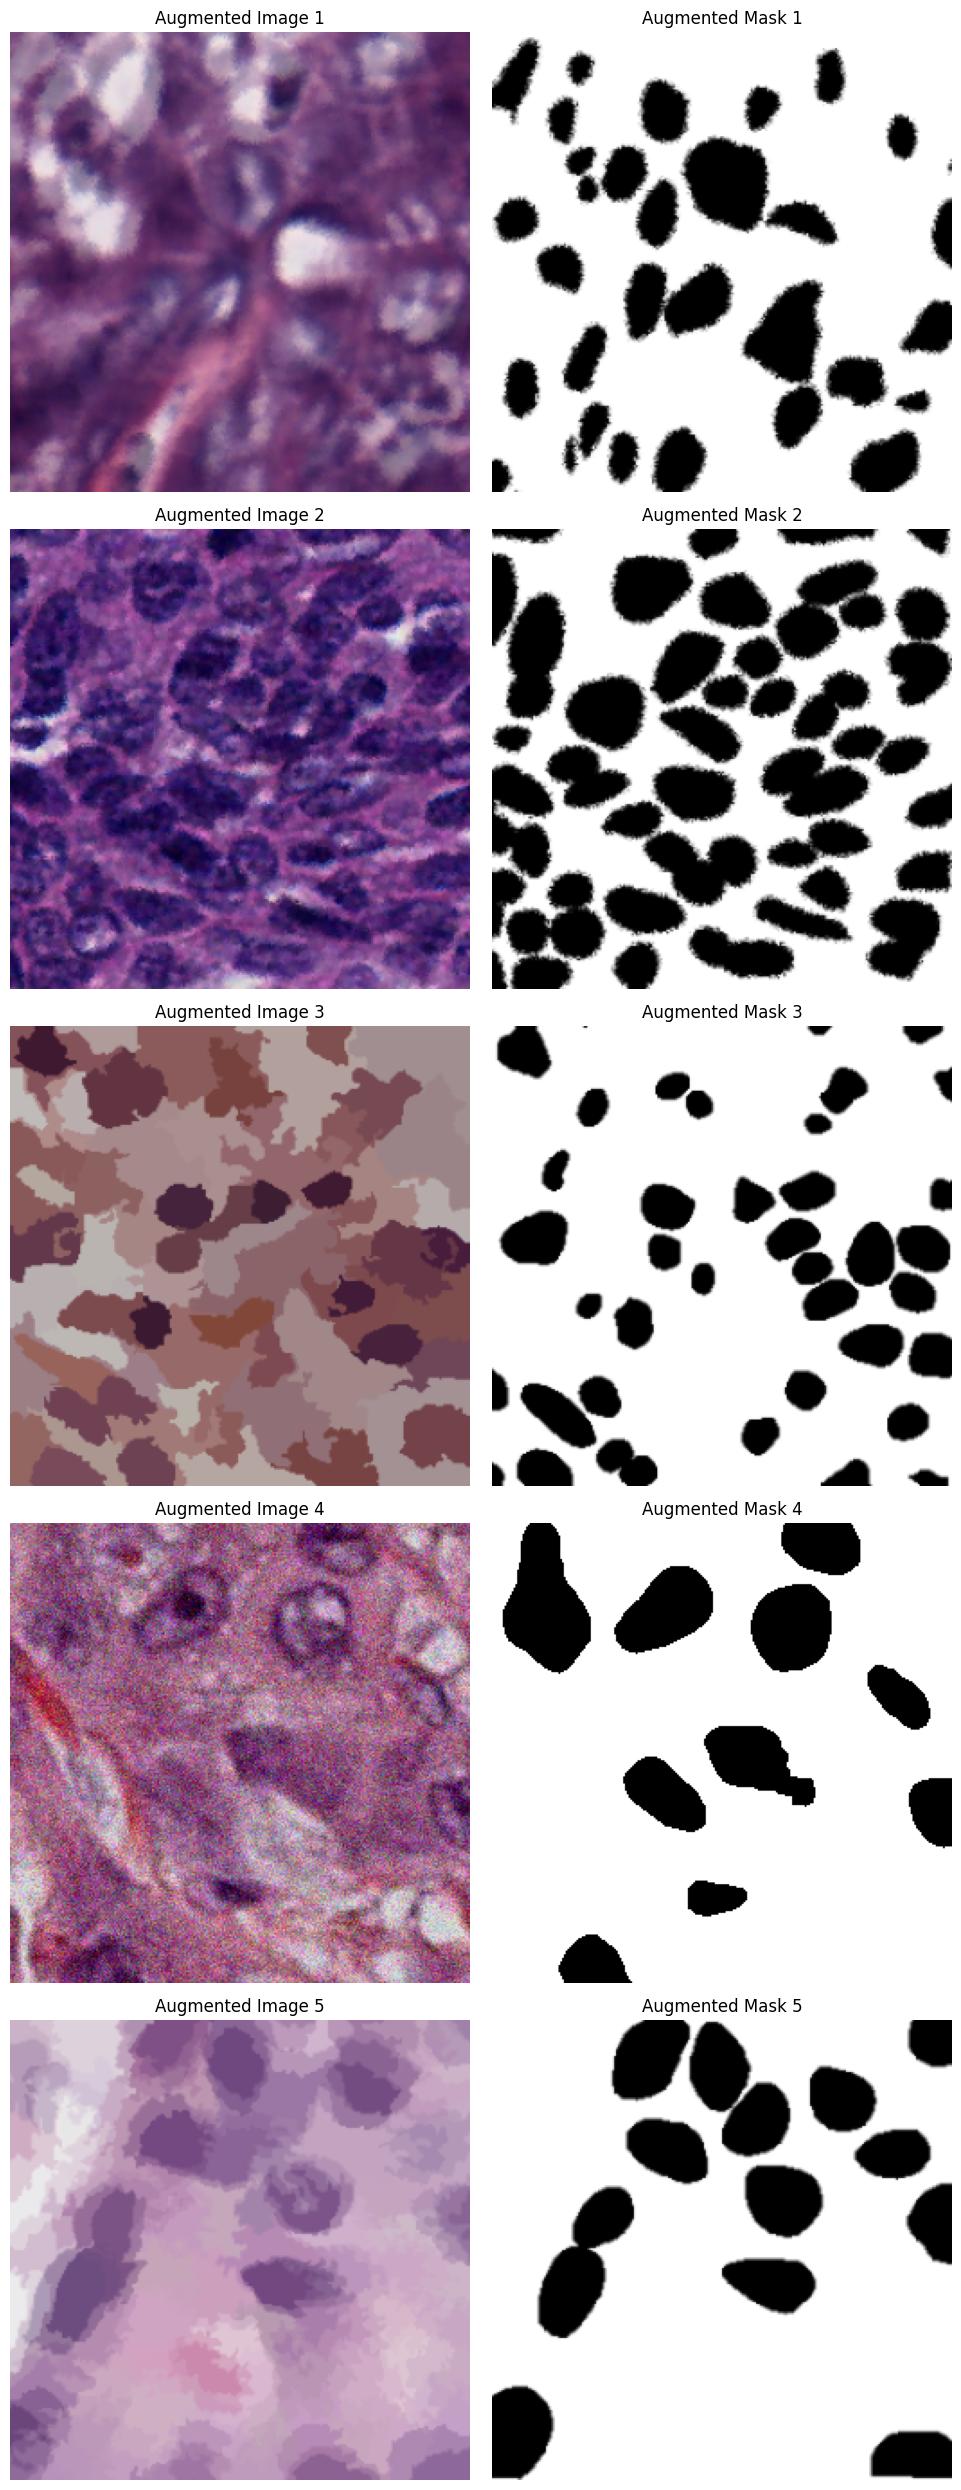

In [3]:
import matplotlib.pyplot as plt

def visualize_augmented_images(dataset, num_samples=5):
    fig, axs = plt.subplots(num_samples, 2, figsize=(10, 5*num_samples))
    for i in range(num_samples):
        image, mask = dataset[i]
        axs[i, 0].imshow(image.permute(1, 2, 0))
        axs[i, 0].set_title(f"Augmented Image {i+1}")
        axs[i, 0].axis('off')
        axs[i, 1].imshow(mask.squeeze(), cmap='gray')
        axs[i, 1].set_title(f"Augmented Mask {i+1}")
        axs[i, 1].axis('off')
    plt.tight_layout()
    plt.show()

# Usage
visualize_augmented_images(train_dataset)

## Data visualization

Visualizing first sample from training dataset:
Original image - min: 18.0, max: 255.0, mean: 118.63621520996094
Normalized image - min: 0.0, max: 1.0, mean: 0.4246253806327465


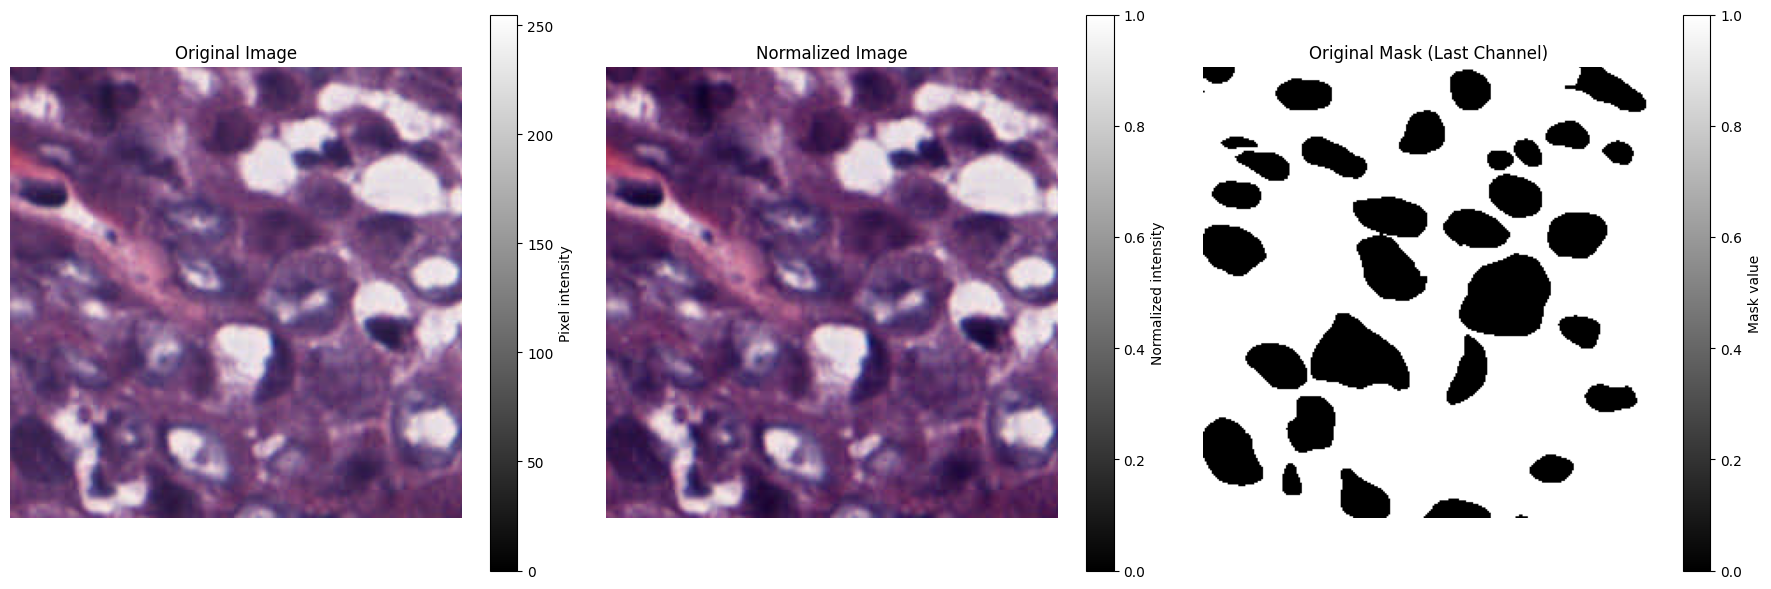

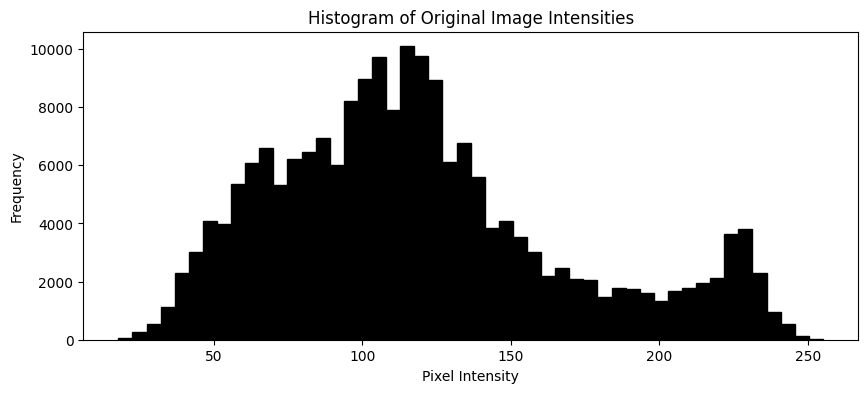

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_single_sample(dataset, index=0):
    # Get the original image and mask
    original_image = dataset.images[index]
    original_mask = dataset.masks[index]

    # Normalize image as done in the dataset class
    normalized_image = (original_image - original_image.min()) / (original_image.max() - original_image.min())

    print(f"Original image - min: {original_image.min()}, max: {original_image.max()}, mean: {original_image.mean()}")
    print(f"Normalized image - min: {normalized_image.min()}, max: {normalized_image.max()}, mean: {normalized_image.mean()}")

    # Create a figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    # Plot the original image
    # Plot the original image with adjusted vmin and vmax
    im1 = ax1.imshow(original_image.astype(np.uint8), cmap='gray', vmin=0, vmax=255)
    ax1.set_title("Original Image")
    ax1.axis('off')
    plt.colorbar(im1, ax=ax1, label='Pixel intensity')

    # Plot the normalized image
    im2 = ax2.imshow(normalized_image, cmap='gray')
    ax2.set_title("Normalized Image")
    ax2.axis('off')
    plt.colorbar(im2, ax=ax2, label='Normalized intensity')

    # Plot the original mask (last channel)
    im3 = ax3.imshow(original_mask[..., -1], cmap='gray')
    ax3.set_title("Original Mask (Last Channel)")
    ax3.axis('off')
    plt.colorbar(im3, ax=ax3, label='Mask value')

    plt.tight_layout()
    plt.show()

    # Display histogram of original image intensities
    plt.figure(figsize=(10, 4))
    plt.hist(original_image.ravel(), bins=50, range=(original_image.min(), original_image.max()), fc='k', ec='k')
    plt.title("Histogram of Original Image Intensities")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.show()

# Visualize the first sample from the training dataset
print("Visualizing first sample from training dataset:")
visualize_single_sample(train_dataset)

Visualizing random samples from training dataset:

Visualiizng sample 296:
Original image - min: 0.0, max: 255.0, mean: 105.95
Normalized image - min: 0.00, max: 1.00, mean: 0.42


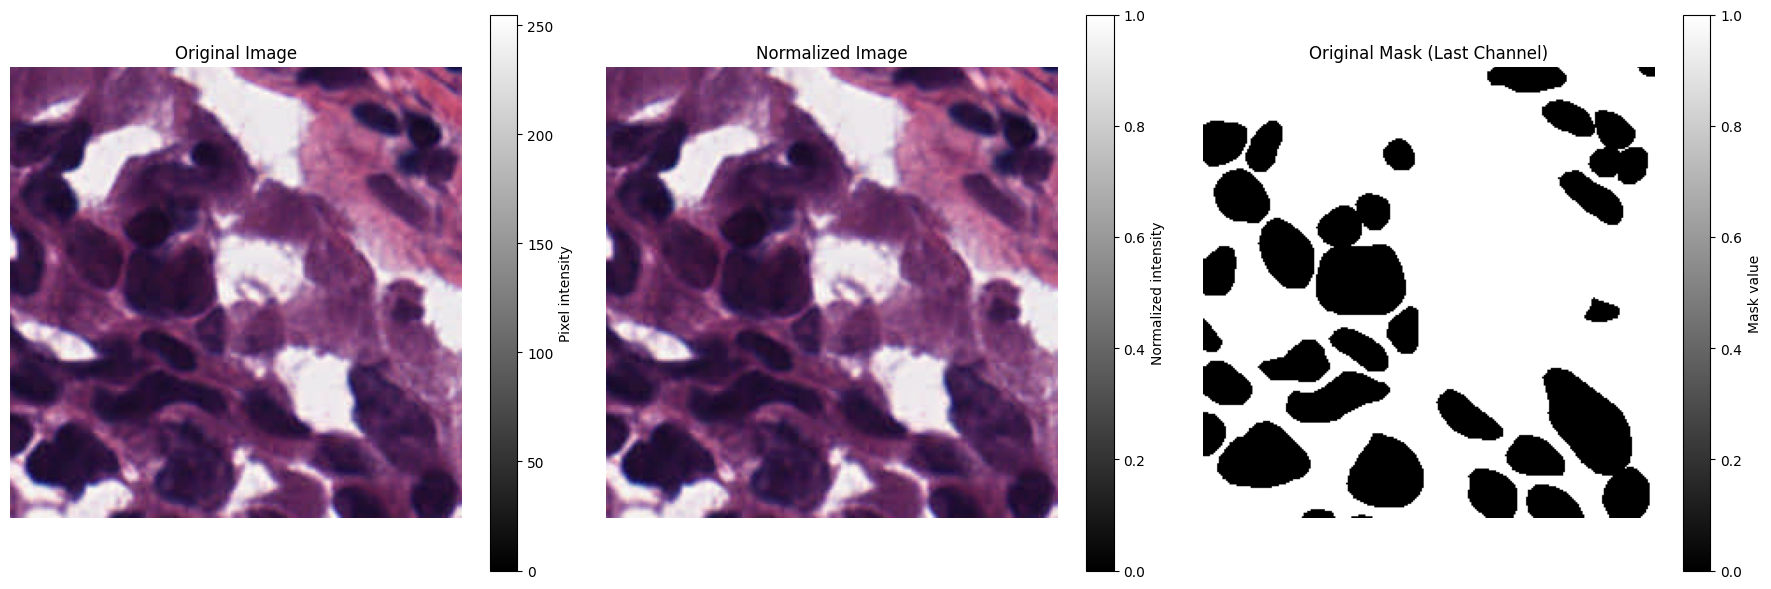


Visualiizng sample 228:
Original image - min: 55.0, max: 255.0, mean: 181.92
Normalized image - min: 0.00, max: 1.00, mean: 0.63


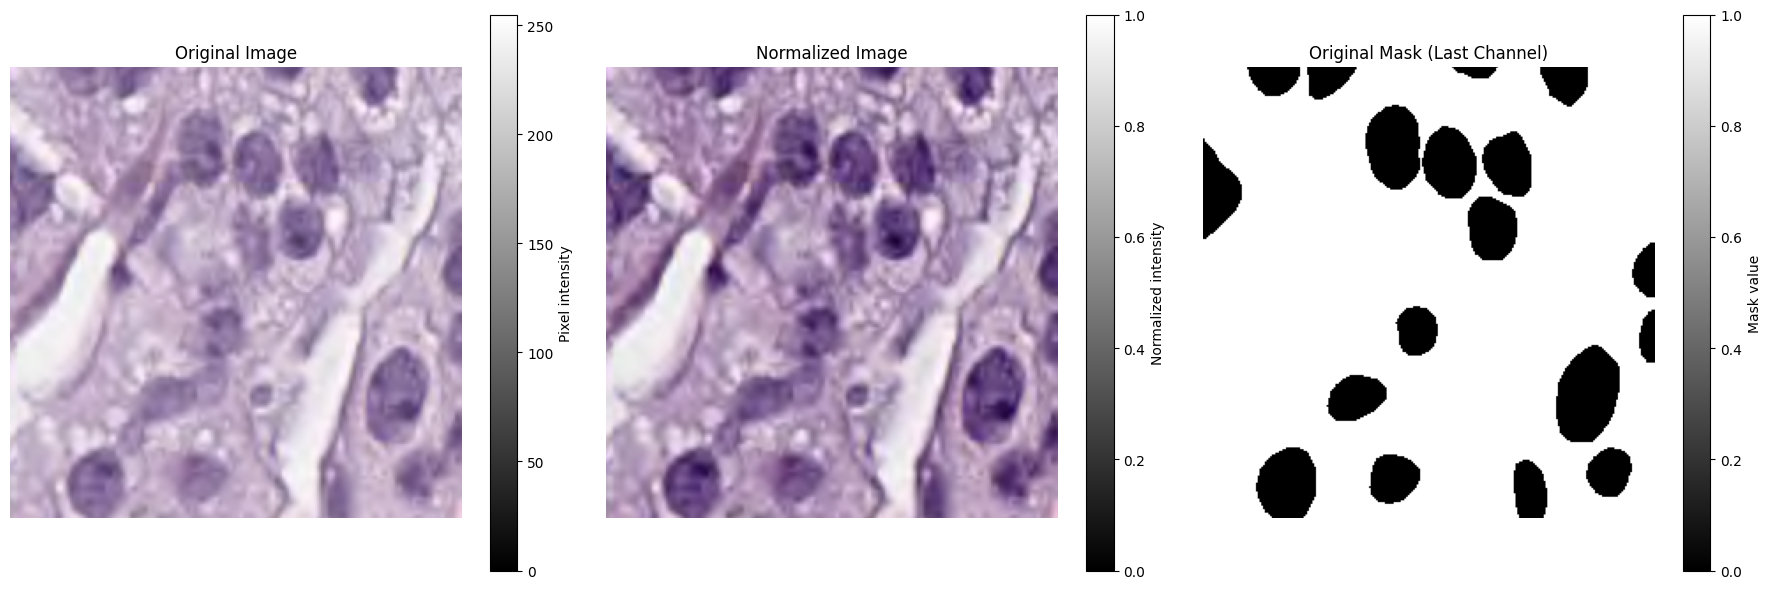


Visualiizng sample 2036:
Original image - min: 26.0, max: 255.0, mean: 136.32
Normalized image - min: 0.00, max: 1.00, mean: 0.48


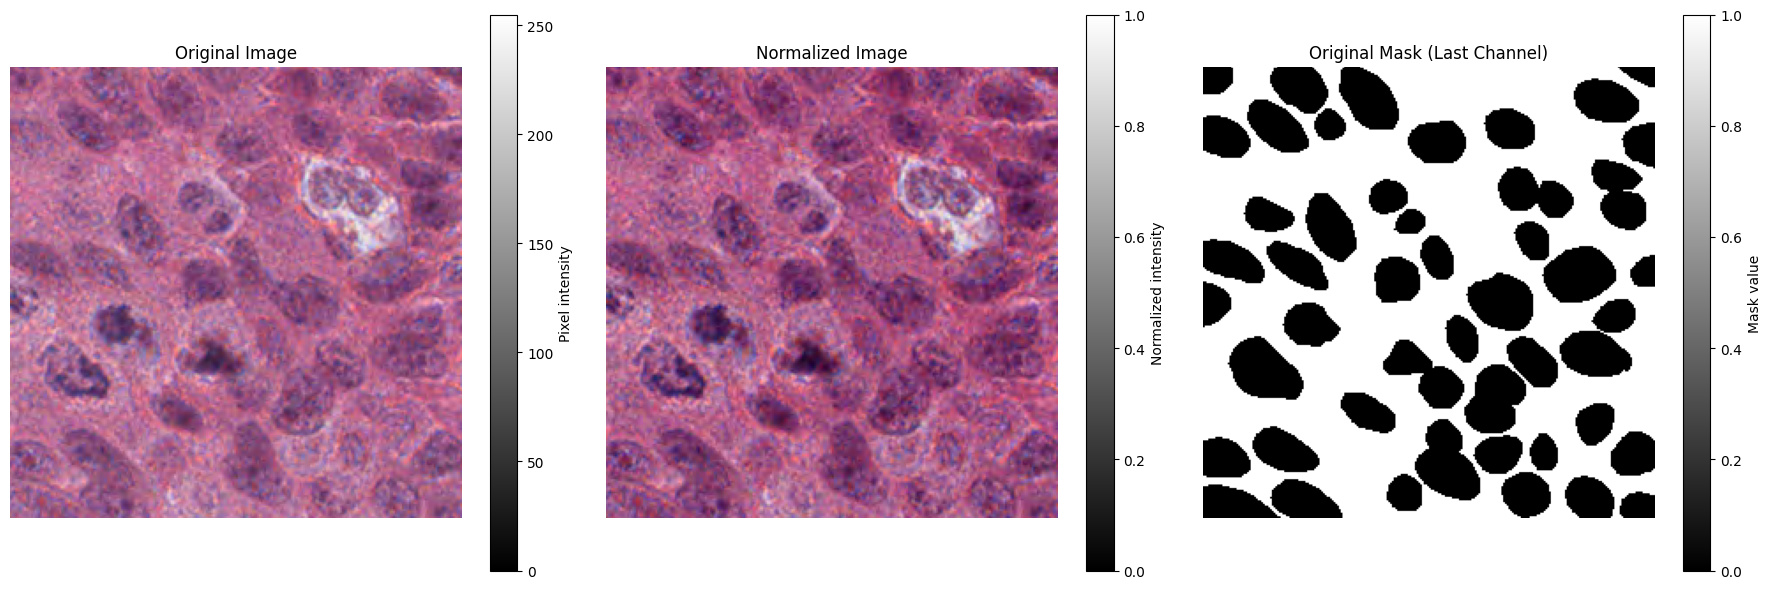

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import random

def visualize_random_samples(dataset, num_samples=3):
    # Get the total number of samples in the dataset
    total_samples = len(dataset)
    
    # Generate random indices
    random_indices = random.sample(range(total_samples), num_samples)
    
    for index in random_indices:
        visualize_single_sample(dataset, index)

def visualize_single_sample(dataset, index):
    # Get the original image and mask
    original_image = dataset.images[index]
    original_mask = dataset.masks[index]

    # Normalize image as done in the dataset class
    normalized_image = (original_image - original_image.min()) / (original_image.max() - original_image.min())

    print(f"\nVisualiizng sample {index}:")
    print(f"Original image - min: {original_image.min()}, max: {original_image.max()}, mean: {original_image.mean():.2f}")
    print(f"Normalized image - min: {normalized_image.min():.2f}, max: {normalized_image.max():.2f}, mean: {normalized_image.mean():.2f}")

    # Create a figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    # Plot the original image
    im1 = ax1.imshow(original_image.astype(np.uint8), cmap='gray', vmin=0, vmax=255)
    ax1.set_title("Original Image")
    ax1.axis('off')
    plt.colorbar(im1, ax=ax1, label='Pixel intensity')

    # Plot the normalized image
    im2 = ax2.imshow(normalized_image, cmap='gray')
    ax2.set_title("Normalized Image")
    ax2.axis('off')
    plt.colorbar(im2, ax=ax2, label='Normalized intensity')

    # Plot the original mask (last channel)
    im3 = ax3.imshow(original_mask[..., -1], cmap='gray')
    ax3.set_title("Original Mask (Last Channel)")
    ax3.axis('off')
    plt.colorbar(im3, ax=ax3, label='Mask value')

    plt.tight_layout()
    plt.show()

    # # Display histogram of original image intensities
    # plt.figure(figsize=(10, 4))
    # plt.hist(original_image.ravel(), bins=50, range=(original_image.min(), original_image.max()), fc='k', ec='k')
    # plt.title(f"Histogram of Original Image Intensities (Sample {index})")
    # plt.xlabel("Pixel Intensity")
    # plt.ylabel("Frequency")
    # plt.show()

# Visualize random samples from the training dataset
print("Visualizing random samples from training dataset:")
visualize_random_samples(train_dataset, num_samples=3)

## model training 

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import swin_t, Swin_T_Weights

class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.norm2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.se = SEBlock(out_channels)

    def forward(self, x):
        x = self.relu(self.norm1(self.conv1(x)))
        x = self.relu(self.norm2(self.conv2(x)))
        x = self.se(x)
        return x

class SwinEncoder(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        if pretrained:
            weights = Swin_T_Weights.IMAGENET1K_V1
        else:
            weights = None
        self.swin = swin_t(weights=weights)
        self.swin.head = nn.Identity()  # Remove the classifier head

    def forward(self, x):
        features = []
        for i, layer in enumerate(self.swin.features):
            x = layer(x)
            if i in [2, 4, 6]:  # Collect features from specific layers
                features.append(x)
        return features

class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class UNetDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder1 = DecoderBlock(768, 384)
        self.decoder2 = DecoderBlock(384 + 384, 192)
        self.decoder3 = DecoderBlock(192 + 192, 96)
        self.decoder4 = DecoderBlock(96 + 192, 48)
        self.final_conv = nn.Conv2d(48, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        
        self.attention1 = AttentionBlock(F_g=384, F_l=384, F_int=192)
        self.attention2 = AttentionBlock(F_g=192, F_l=192, F_int=96)
        self.attention3 = AttentionBlock(F_g=96, F_l=192, F_int=48)

    def forward(self, features):
        x = features[-1]
        x = x.permute(0, 3, 1, 2)  # Change from [B, H, W, C] to [B, C, H, W]
        x = self.decoder1(x)
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        
        skip1 = F.interpolate(features[-2].permute(0, 3, 1, 2), size=x.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, self.attention1(x, skip1)], dim=1)
        x = self.decoder2(x)
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        
        skip2 = F.interpolate(features[-3].permute(0, 3, 1, 2), size=x.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, self.attention2(x, skip2)], dim=1)
        x = self.decoder3(x)
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        
        skip3 = F.interpolate(features[0].permute(0, 3, 1, 2), size=x.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, self.attention3(x, skip3)], dim=1)
        x = self.decoder4(x)
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        
        x = self.final_conv(x)
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)  # Final upsampling to match input size
        return self.sigmoid(x)

class CellSwin(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = SwinEncoder()
        self.decoder = UNetDecoder()

    def forward(self, x):
        features = self.encoder(x)
        output = self.decoder(features)
        return output

# Initialize the model
model = CellSwin().float()
print("Improved Swin Transformer-based model defined.")

Improved Swin Transformer-based model defined.


## New Model

In [7]:
class FocalDiceLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, smooth=1e-5):
        super(FocalDiceLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.smooth = smooth

    def forward(self, pred, target):
        # Focal Loss
        bce = F.binary_cross_entropy(pred, target, reduction='none')
        pt = torch.exp(-bce)
        focal_loss = self.alpha * (1-pt)**self.gamma * bce
        focal_loss = focal_loss.mean()

        # Dice Loss
        pred = pred.view(-1)
        target = target.view(-1)
        intersection = (pred * target).sum()
        dice = 1 - (2. * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)

        return focal_loss + dice

def iou_score(pred, target, smooth=1e-5, threshold=0.3):
    pred = (pred > threshold).float()
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    union = (pred + target).sum() - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

print("Loss function and metrics defined.")



Loss function and metrics defined.


In [8]:
import numpy as np
from scipy import ndimage
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torch
import numpy as np
from scipy import ndimage


def calculate_object_based_metrics(true_mask, pred_mask, distance_threshold=12):
    def get_centroids(mask):
        mask_np = mask.cpu().numpy() if isinstance(mask, torch.Tensor) else mask
        labeled, num_objects = ndimage.label(mask_np)
        if num_objects == 0:
            return np.array([])
        centroids = ndimage.center_of_mass(mask_np, labeled, range(1, num_objects+1))
        return np.array(centroids)

    true_centroids = get_centroids(true_mask)
    pred_centroids = get_centroids(pred_mask)

    if len(true_centroids) == 0 and len(pred_centroids) == 0:
        return 1.0, 1.0, 1.0  # Perfect score if both are empty
    elif len(true_centroids) == 0:
        return 0.0, 0.0, 0.0  # All false positives
    elif len(pred_centroids) == 0:
        return 0.0, 0.0, 0.0  # All false negatives

    matched = set()
    tp = 0

    for pred_centroid in pred_centroids:
        distances = np.sqrt(((true_centroids - pred_centroid[np.newaxis, :]) ** 2).sum(axis=1))
        if distances.size > 0 and np.min(distances) <= distance_threshold:
            match_idx = np.argmin(distances)
            if match_idx not in matched:
                tp += 1
                matched.add(match_idx)

    fp = len(pred_centroids) - tp
    fn = len(true_centroids) - tp

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1

In [9]:
import torch
from tqdm import tqdm
import os
import numpy as np

def train_model(model, train_loader, val_loader, num_epochs=100, patience=20, save_dir='models'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = FocalDiceLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
    
    os.makedirs(save_dir, exist_ok=True)
    best_val_loss = float('inf')
    best_model = None
    counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_iou = 0
        train_precision = 0
        train_recall = 0
        train_f1 = 0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training")
        for images, masks in train_bar:
            images = images.float().to(device)
            masks = masks.float().to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_iou += iou_score(outputs, masks).item()
            
            # Calculate object-based metrics
            pred_masks = (outputs > 0.5).float()
            batch_precision, batch_recall, batch_f1 = 0, 0, 0
            for true_mask, pred_mask in zip(masks, pred_masks):
                p, r, f = calculate_object_based_metrics(true_mask, pred_mask)
                batch_precision += p
                batch_recall += r
                batch_f1 += f
            
            train_precision += batch_precision / len(masks)
            train_recall += batch_recall / len(masks)
            train_f1 += batch_f1 / len(masks)
            
            train_bar.set_postfix({
                'loss': f"{loss.item():.4f}", 
                'iou': f"{iou_score(outputs, masks).item():.4f}",
                'precision': f"{batch_precision / len(masks):.4f}",
                'recall': f"{batch_recall / len(masks):.4f}",
                'f1': f"{batch_f1 / len(masks):.4f}"
            })
        
        avg_train_loss = train_loss / len(train_loader)
        avg_train_iou = train_iou / len(train_loader)
        avg_train_precision = train_precision / len(train_loader)
        avg_train_recall = train_recall / len(train_loader)
        avg_train_f1 = train_f1 / len(train_loader)
        
        # Validation
        model.eval()
        val_loss = 0
        val_iou = 0
        val_precision = 0
        val_recall = 0
        val_f1 = 0
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation")
        with torch.no_grad():
            for images, masks in val_bar:
                images = images.float().to(device)
                masks = masks.float().to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                val_iou += iou_score(outputs, masks).item()
                
                # Calculate object-based metrics
                pred_masks = (outputs > 0.5).float()
                batch_precision, batch_recall, batch_f1 = 0, 0, 0
                for true_mask, pred_mask in zip(masks, pred_masks):
                    p, r, f = calculate_object_based_metrics(true_mask, pred_mask)
                    batch_precision += p
                    batch_recall += r
                    batch_f1 += f
                
                val_precision += batch_precision / len(masks)
                val_recall += batch_recall / len(masks)
                val_f1 += batch_f1 / len(masks)
                
                val_bar.set_postfix({
                    'loss': f"{loss.item():.4f}", 
                    'iou': f"{iou_score(outputs, masks).item():.4f}",
                    'precision': f"{batch_precision / len(masks):.4f}",
                    'recall': f"{batch_recall / len(masks):.4f}",
                    'f1': f"{batch_f1 / len(masks):.4f}"
                })
        
        avg_val_loss = val_loss / len(val_loader)
        avg_val_iou = val_iou / len(val_loader)
        avg_val_precision = val_precision / len(val_loader)
        avg_val_recall = val_recall / len(val_loader)
        avg_val_f1 = val_f1 / len(val_loader)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {avg_train_loss:.4f}, Train IoU: {avg_train_iou:.4f}, Train Precision: {avg_train_precision:.4f}, Train Recall: {avg_train_recall:.4f}, Train F1: {avg_train_f1:.4f}')
        print(f'Val Loss: {avg_val_loss:.4f}, Val IoU: {avg_val_iou:.4f}, Val Precision: {avg_val_precision:.4f}, Val Recall: {avg_val_recall:.4f}, Val F1: {avg_val_f1:.4f}')
        
        scheduler.step(avg_val_loss)
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model = model.state_dict()
            counter = 0
            save_path = os.path.join(save_dir, 'v4.pth')
            torch.save(best_model, save_path)
            print(f"Saved best model with validation loss: {best_val_loss:.4f}")
        else:
            counter += 1
        
        if counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break
    
    model.load_state_dict(best_model)
    return model

print("Updated training function with precision, recall, and F1 score calculations.")

Updated training function with precision, recall, and F1 score calculations.


In [10]:
!pwd

/rsrch5/home/plm/yshokrollahi/vitamin-p/new-vitamin-p


In [11]:
# Initialize the model
model = CellSwin().float()

# Train the model
trained_model = train_model(model, train_loader, val_loader, num_epochs=100, patience=100, save_dir='models/')

Epoch 1/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.90it/s, loss=0.2671, iou=0.8623, precision=0.4213, recall=0.4241, f1=0.3248]


Epoch 1/100:
Train Loss: 0.3314, Train IoU: 0.8476, Train Precision: 0.4102, Train Recall: 0.4831, Train F1: 0.3884
Val Loss: 0.2665, Val IoU: 0.8814, Val Precision: 0.5709, Val Recall: 0.5480, Val F1: 0.4987
Saved best model with validation loss: 0.2665


Epoch 2/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.86it/s, loss=0.2304, iou=0.8836, precision=0.6333, recall=0.4241, f1=0.4635]


Epoch 2/100:
Train Loss: 0.2608, Train IoU: 0.8568, Train Precision: 0.6416, Train Recall: 0.6496, Train F1: 0.5784
Val Loss: 0.2198, Val IoU: 0.8944, Val Precision: 0.6665, Val Recall: 0.5722, Val F1: 0.5653
Saved best model with validation loss: 0.2198


Epoch 3/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.80it/s, loss=0.1746, iou=0.8893, precision=0.7308, recall=0.4500, f1=0.5007]


Epoch 3/100:
Train Loss: 0.2071, Train IoU: 0.8610, Train Precision: 0.7463, Train Recall: 0.7088, Train F1: 0.6581
Val Loss: 0.1610, Val IoU: 0.8963, Val Precision: 0.7037, Val Recall: 0.5775, Val F1: 0.5811
Saved best model with validation loss: 0.1610


Epoch 4/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.82it/s, loss=0.1523, iou=0.8858, precision=0.9136, recall=0.4981, f1=0.5811]


Epoch 4/100:
Train Loss: 0.1652, Train IoU: 0.8642, Train Precision: 0.7845, Train Recall: 0.7345, Train F1: 0.6884
Val Loss: 0.1375, Val IoU: 0.8950, Val Precision: 0.8086, Val Recall: 0.6010, Val F1: 0.6263
Saved best model with validation loss: 0.1375


Epoch 5/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.73it/s, loss=0.1222, iou=0.8843, precision=0.8704, recall=0.4981, f1=0.5743]


Epoch 5/100:
Train Loss: 0.1432, Train IoU: 0.8657, Train Precision: 0.7922, Train Recall: 0.7379, Train F1: 0.6924
Val Loss: 0.1104, Val IoU: 0.8951, Val Precision: 0.8246, Val Recall: 0.6082, Val F1: 0.6320
Saved best model with validation loss: 0.1104


Epoch 6/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.74it/s, loss=0.1281, iou=0.8974, precision=0.7444, recall=0.4870, f1=0.5450]


Epoch 6/100:
Train Loss: 0.1315, Train IoU: 0.8670, Train Precision: 0.8006, Train Recall: 0.7392, Train F1: 0.6934
Val Loss: 0.1152, Val IoU: 0.9061, Val Precision: 0.7223, Val Recall: 0.5984, Val F1: 0.5938


Epoch 7/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.79it/s, loss=0.0970, iou=0.8813, precision=0.8333, recall=0.4981, f1=0.5450]


Epoch 7/100:
Train Loss: 0.1228, Train IoU: 0.8692, Train Precision: 0.8007, Train Recall: 0.7429, Train F1: 0.6990
Val Loss: 0.0838, Val IoU: 0.8984, Val Precision: 0.8572, Val Recall: 0.6076, Val F1: 0.6380
Saved best model with validation loss: 0.0838


Epoch 8/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.81it/s, loss=0.1017, iou=0.9010, precision=0.6556, recall=0.4981, f1=0.5414]


Epoch 8/100:
Train Loss: 0.1198, Train IoU: 0.8707, Train Precision: 0.7911, Train Recall: 0.7423, Train F1: 0.6943
Val Loss: 0.0885, Val IoU: 0.9057, Val Precision: 0.8011, Val Recall: 0.6076, Val F1: 0.6290


Epoch 9/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.97it/s, loss=0.0935, iou=0.8943, precision=0.8889, recall=0.4981, f1=0.5783]


Epoch 9/100:
Train Loss: 0.1156, Train IoU: 0.8732, Train Precision: 0.8057, Train Recall: 0.7455, Train F1: 0.7029
Val Loss: 0.0830, Val IoU: 0.9098, Val Precision: 0.8316, Val Recall: 0.5976, Val F1: 0.6285
Saved best model with validation loss: 0.0830


Epoch 10/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.74it/s, loss=0.0933, iou=0.9038, precision=0.7148, recall=0.5093, f1=0.5373]


Epoch 10/100:
Train Loss: 0.1144, Train IoU: 0.8743, Train Precision: 0.7962, Train Recall: 0.7446, Train F1: 0.6959
Val Loss: 0.0795, Val IoU: 0.9126, Val Precision: 0.7859, Val Recall: 0.6041, Val F1: 0.6210
Saved best model with validation loss: 0.0795


Epoch 11/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.86it/s, loss=0.0880, iou=0.8938, precision=0.7222, recall=0.4981, f1=0.5270]


Epoch 11/100:
Train Loss: 0.1120, Train IoU: 0.8757, Train Precision: 0.7961, Train Recall: 0.7409, Train F1: 0.6948
Val Loss: 0.0801, Val IoU: 0.9100, Val Precision: 0.8162, Val Recall: 0.5796, Val F1: 0.6096


Epoch 12/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.01it/s, loss=0.0875, iou=0.8935, precision=0.9444, recall=0.4981, f1=0.5894]


Epoch 12/100:
Train Loss: 0.1143, Train IoU: 0.8743, Train Precision: 0.7970, Train Recall: 0.7483, Train F1: 0.6986
Val Loss: 0.0730, Val IoU: 0.9115, Val Precision: 0.8403, Val Recall: 0.6061, Val F1: 0.6346
Saved best model with validation loss: 0.0730


Epoch 13/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.93it/s, loss=0.0922, iou=0.9033, precision=0.7426, recall=0.5093, f1=0.5320]


Epoch 13/100:
Train Loss: 0.1095, Train IoU: 0.8772, Train Precision: 0.7923, Train Recall: 0.7441, Train F1: 0.6924
Val Loss: 0.0771, Val IoU: 0.9210, Val Precision: 0.7906, Val Recall: 0.6086, Val F1: 0.6242


Epoch 14/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.84it/s, loss=0.0893, iou=0.8965, precision=0.7222, recall=0.4981, f1=0.5320]


Epoch 14/100:
Train Loss: 0.1104, Train IoU: 0.8767, Train Precision: 0.8088, Train Recall: 0.7459, Train F1: 0.7019
Val Loss: 0.0795, Val IoU: 0.9060, Val Precision: 0.8290, Val Recall: 0.6088, Val F1: 0.6334


Epoch 15/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.60it/s, loss=0.0889, iou=0.8985, precision=0.7963, recall=0.4981, f1=0.5456]


Epoch 15/100:
Train Loss: 0.1103, Train IoU: 0.8767, Train Precision: 0.8101, Train Recall: 0.7481, Train F1: 0.7060
Val Loss: 0.0761, Val IoU: 0.9087, Val Precision: 0.8493, Val Recall: 0.6046, Val F1: 0.6345


Epoch 16/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.80it/s, loss=0.0857, iou=0.9043, precision=0.9259, recall=0.5167, f1=0.6093]


Epoch 16/100:
Train Loss: 0.1106, Train IoU: 0.8777, Train Precision: 0.8155, Train Recall: 0.7400, Train F1: 0.7018
Val Loss: 0.0730, Val IoU: 0.9229, Val Precision: 0.8164, Val Recall: 0.6091, Val F1: 0.6319
Saved best model with validation loss: 0.0730


Epoch 17/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.68it/s, loss=0.0833, iou=0.9019, precision=0.8222, recall=0.4981, f1=0.5463]


Epoch 17/100:
Train Loss: 0.1085, Train IoU: 0.8794, Train Precision: 0.8199, Train Recall: 0.7517, Train F1: 0.7150
Val Loss: 0.0731, Val IoU: 0.9192, Val Precision: 0.8563, Val Recall: 0.6078, Val F1: 0.6417


Epoch 18/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.68it/s, loss=0.0824, iou=0.9049, precision=0.8148, recall=0.4981, f1=0.5656]


Epoch 18/100:
Train Loss: 0.1060, Train IoU: 0.8812, Train Precision: 0.8164, Train Recall: 0.7516, Train F1: 0.7111
Val Loss: 0.0735, Val IoU: 0.9128, Val Precision: 0.8386, Val Recall: 0.6069, Val F1: 0.6359


Epoch 19/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.70it/s, loss=0.0845, iou=0.9010, precision=0.7778, recall=0.4981, f1=0.5690]


Epoch 19/100:
Train Loss: 0.1097, Train IoU: 0.8785, Train Precision: 0.8162, Train Recall: 0.7533, Train F1: 0.7126
Val Loss: 0.0716, Val IoU: 0.9174, Val Precision: 0.8631, Val Recall: 0.6078, Val F1: 0.6440
Saved best model with validation loss: 0.0716


Epoch 20/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.77it/s, loss=0.0881, iou=0.9007, precision=0.6984, recall=0.4981, f1=0.5523]


Epoch 20/100:
Train Loss: 0.1085, Train IoU: 0.8789, Train Precision: 0.8169, Train Recall: 0.7404, Train F1: 0.7022
Val Loss: 0.0759, Val IoU: 0.9144, Val Precision: 0.8263, Val Recall: 0.6085, Val F1: 0.6355


Epoch 21/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.89it/s, loss=0.0837, iou=0.9052, precision=0.8704, recall=0.4981, f1=0.5802]


Epoch 21/100:
Train Loss: 0.1075, Train IoU: 0.8806, Train Precision: 0.8147, Train Recall: 0.7525, Train F1: 0.7115
Val Loss: 0.0739, Val IoU: 0.9216, Val Precision: 0.8168, Val Recall: 0.6022, Val F1: 0.6257


Epoch 22/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.54it/s, loss=0.0877, iou=0.8997, precision=0.7407, recall=0.4981, f1=0.5286]


Epoch 22/100:
Train Loss: 0.1047, Train IoU: 0.8817, Train Precision: 0.8247, Train Recall: 0.7486, Train F1: 0.7141
Val Loss: 0.0748, Val IoU: 0.9134, Val Precision: 0.8496, Val Recall: 0.6057, Val F1: 0.6367


Epoch 23/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.02it/s, loss=0.0828, iou=0.9087, precision=0.7222, recall=0.5093, f1=0.5352]


Epoch 23/100:
Train Loss: 0.1062, Train IoU: 0.8807, Train Precision: 0.8221, Train Recall: 0.7540, Train F1: 0.7149
Val Loss: 0.0735, Val IoU: 0.9238, Val Precision: 0.8035, Val Recall: 0.5943, Val F1: 0.6173
Epoch 00023: reducing learning rate of group 0 to 1.0000e-05.


Epoch 24/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.83it/s, loss=0.0830, iou=0.9042, precision=0.8333, recall=0.5093, f1=0.5775]


Epoch 24/100:
Train Loss: 0.0993, Train IoU: 0.8869, Train Precision: 0.8107, Train Recall: 0.7445, Train F1: 0.7023
Val Loss: 0.0684, Val IoU: 0.9230, Val Precision: 0.8422, Val Recall: 0.6052, Val F1: 0.6384
Saved best model with validation loss: 0.0684


Epoch 25/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.79it/s, loss=0.0824, iou=0.9074, precision=0.8333, recall=0.4981, f1=0.5743]


Epoch 25/100:
Train Loss: 0.0991, Train IoU: 0.8872, Train Precision: 0.8168, Train Recall: 0.7600, Train F1: 0.7164
Val Loss: 0.0685, Val IoU: 0.9262, Val Precision: 0.8412, Val Recall: 0.6055, Val F1: 0.6391


Epoch 26/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.78it/s, loss=0.0830, iou=0.9072, precision=0.8148, recall=0.4981, f1=0.5669]


Epoch 26/100:
Train Loss: 0.0983, Train IoU: 0.8882, Train Precision: 0.8236, Train Recall: 0.7636, Train F1: 0.7227
Val Loss: 0.0673, Val IoU: 0.9269, Val Precision: 0.8458, Val Recall: 0.6120, Val F1: 0.6462
Saved best model with validation loss: 0.0673


Epoch 27/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.95it/s, loss=0.0821, iou=0.9070, precision=0.8148, recall=0.4981, f1=0.5656]


Epoch 27/100:
Train Loss: 0.0980, Train IoU: 0.8884, Train Precision: 0.8233, Train Recall: 0.7592, Train F1: 0.7192
Val Loss: 0.0675, Val IoU: 0.9258, Val Precision: 0.8603, Val Recall: 0.6144, Val F1: 0.6528


Epoch 28/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.14it/s, loss=0.0822, iou=0.9064, precision=0.8333, recall=0.4981, f1=0.5802]


Epoch 28/100:
Train Loss: 0.0962, Train IoU: 0.8910, Train Precision: 0.8281, Train Recall: 0.7523, Train F1: 0.7171
Val Loss: 0.0683, Val IoU: 0.9242, Val Precision: 0.8607, Val Recall: 0.6117, Val F1: 0.6514


Epoch 29/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.74it/s, loss=0.0836, iou=0.9082, precision=0.8056, recall=0.4981, f1=0.5616]


Epoch 29/100:
Train Loss: 0.0963, Train IoU: 0.8907, Train Precision: 0.8204, Train Recall: 0.7610, Train F1: 0.7198
Val Loss: 0.0681, Val IoU: 0.9262, Val Precision: 0.8454, Val Recall: 0.6094, Val F1: 0.6434


Epoch 30/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.01it/s, loss=0.0830, iou=0.9079, precision=0.8148, recall=0.4981, f1=0.5669]


Epoch 30/100:
Train Loss: 0.0963, Train IoU: 0.8905, Train Precision: 0.8275, Train Recall: 0.7619, Train F1: 0.7232
Val Loss: 0.0684, Val IoU: 0.9255, Val Precision: 0.8507, Val Recall: 0.6139, Val F1: 0.6487
Epoch 00030: reducing learning rate of group 0 to 1.0000e-06.


Epoch 31/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.87it/s, loss=0.0819, iou=0.9051, precision=0.7963, recall=0.4981, f1=0.5715]


Epoch 31/100:
Train Loss: 0.0965, Train IoU: 0.8906, Train Precision: 0.8242, Train Recall: 0.7548, Train F1: 0.7152
Val Loss: 0.0673, Val IoU: 0.9240, Val Precision: 0.8601, Val Recall: 0.6136, Val F1: 0.6488
Saved best model with validation loss: 0.0673


Epoch 32/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.89it/s, loss=0.0827, iou=0.9075, precision=0.8333, recall=0.4981, f1=0.5694]


Epoch 32/100:
Train Loss: 0.0960, Train IoU: 0.8914, Train Precision: 0.8252, Train Recall: 0.7566, Train F1: 0.7171
Val Loss: 0.0679, Val IoU: 0.9253, Val Precision: 0.8576, Val Recall: 0.6138, Val F1: 0.6504


Epoch 33/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.78it/s, loss=0.0818, iou=0.9070, precision=0.8519, recall=0.4981, f1=0.5768]


Epoch 33/100:
Train Loss: 0.0965, Train IoU: 0.8905, Train Precision: 0.8246, Train Recall: 0.7591, Train F1: 0.7176
Val Loss: 0.0676, Val IoU: 0.9246, Val Precision: 0.8568, Val Recall: 0.6134, Val F1: 0.6491


Epoch 34/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.00it/s, loss=0.0825, iou=0.9061, precision=0.8333, recall=0.4981, f1=0.5694]


Epoch 34/100:
Train Loss: 0.0957, Train IoU: 0.8917, Train Precision: 0.8313, Train Recall: 0.7478, Train F1: 0.7144
Val Loss: 0.0675, Val IoU: 0.9255, Val Precision: 0.8589, Val Recall: 0.6141, Val F1: 0.6483


Epoch 35/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.79it/s, loss=0.0826, iou=0.9067, precision=0.8519, recall=0.4981, f1=0.5826]


Epoch 35/100:
Train Loss: 0.0951, Train IoU: 0.8913, Train Precision: 0.8284, Train Recall: 0.7672, Train F1: 0.7272
Val Loss: 0.0679, Val IoU: 0.9249, Val Precision: 0.8577, Val Recall: 0.6122, Val F1: 0.6485
Epoch 00035: reducing learning rate of group 0 to 1.0000e-07.


Epoch 36/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.02it/s, loss=0.0824, iou=0.9071, precision=0.8333, recall=0.4981, f1=0.5743]


Epoch 36/100:
Train Loss: 0.0959, Train IoU: 0.8910, Train Precision: 0.8254, Train Recall: 0.7670, Train F1: 0.7274
Val Loss: 0.0679, Val IoU: 0.9249, Val Precision: 0.8620, Val Recall: 0.6142, Val F1: 0.6525


Epoch 37/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.18it/s, loss=0.0828, iou=0.9062, precision=0.7963, recall=0.4981, f1=0.5715]


Epoch 37/100:
Train Loss: 0.0956, Train IoU: 0.8913, Train Precision: 0.8291, Train Recall: 0.7511, Train F1: 0.7138
Val Loss: 0.0675, Val IoU: 0.9260, Val Precision: 0.8553, Val Recall: 0.6136, Val F1: 0.6473


Epoch 38/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.16it/s, loss=0.0828, iou=0.9067, precision=0.9074, recall=0.4981, f1=0.5879]


Epoch 38/100:
Train Loss: 0.0966, Train IoU: 0.8906, Train Precision: 0.8261, Train Recall: 0.7570, Train F1: 0.7186
Val Loss: 0.0682, Val IoU: 0.9247, Val Precision: 0.8661, Val Recall: 0.6131, Val F1: 0.6519


Epoch 39/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.03it/s, loss=0.0819, iou=0.9078, precision=0.8148, recall=0.4981, f1=0.5669]


Epoch 39/100:
Train Loss: 0.0951, Train IoU: 0.8907, Train Precision: 0.8243, Train Recall: 0.7546, Train F1: 0.7149
Val Loss: 0.0677, Val IoU: 0.9253, Val Precision: 0.8610, Val Recall: 0.6147, Val F1: 0.6520
Epoch 00039: reducing learning rate of group 0 to 1.0000e-08.


Epoch 40/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.34it/s, loss=0.0824, iou=0.9065, precision=0.7778, recall=0.4981, f1=0.5641]


Epoch 40/100:
Train Loss: 0.0957, Train IoU: 0.8907, Train Precision: 0.8298, Train Recall: 0.7602, Train F1: 0.7226
Val Loss: 0.0673, Val IoU: 0.9261, Val Precision: 0.8528, Val Recall: 0.6132, Val F1: 0.6483


Epoch 41/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.44it/s, loss=0.0821, iou=0.9083, precision=0.8333, recall=0.4981, f1=0.5743]


Epoch 41/100:
Train Loss: 0.0955, Train IoU: 0.8904, Train Precision: 0.8300, Train Recall: 0.7491, Train F1: 0.7150
Val Loss: 0.0680, Val IoU: 0.9252, Val Precision: 0.8583, Val Recall: 0.6132, Val F1: 0.6508


Epoch 42/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.97it/s, loss=0.0824, iou=0.9050, precision=0.8519, recall=0.4981, f1=0.5826]


Epoch 42/100:
Train Loss: 0.0953, Train IoU: 0.8909, Train Precision: 0.8298, Train Recall: 0.7587, Train F1: 0.7212
Val Loss: 0.0674, Val IoU: 0.9251, Val Precision: 0.8562, Val Recall: 0.6160, Val F1: 0.6482


Epoch 43/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.95it/s, loss=0.0822, iou=0.9075, precision=0.8519, recall=0.4981, f1=0.5768]


Epoch 43/100:
Train Loss: 0.0965, Train IoU: 0.8908, Train Precision: 0.8297, Train Recall: 0.7630, Train F1: 0.7256
Val Loss: 0.0677, Val IoU: 0.9254, Val Precision: 0.8593, Val Recall: 0.6135, Val F1: 0.6500


Epoch 44/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.00it/s, loss=0.0821, iou=0.9065, precision=0.8333, recall=0.4981, f1=0.5694]


Epoch 44/100:
Train Loss: 0.0942, Train IoU: 0.8924, Train Precision: 0.8253, Train Recall: 0.7595, Train F1: 0.7214
Val Loss: 0.0675, Val IoU: 0.9249, Val Precision: 0.8663, Val Recall: 0.6153, Val F1: 0.6512


Epoch 45/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.84it/s, loss=0.0818, iou=0.9068, precision=0.7778, recall=0.4981, f1=0.5641]


Epoch 45/100:
Train Loss: 0.0959, Train IoU: 0.8924, Train Precision: 0.8232, Train Recall: 0.7539, Train F1: 0.7162
Val Loss: 0.0676, Val IoU: 0.9251, Val Precision: 0.8635, Val Recall: 0.6134, Val F1: 0.6493


Epoch 46/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.90it/s, loss=0.0821, iou=0.9060, precision=0.8519, recall=0.4981, f1=0.5826]


Epoch 46/100:
Train Loss: 0.0961, Train IoU: 0.8905, Train Precision: 0.8293, Train Recall: 0.7565, Train F1: 0.7199
Val Loss: 0.0672, Val IoU: 0.9254, Val Precision: 0.8548, Val Recall: 0.6132, Val F1: 0.6450
Saved best model with validation loss: 0.0672


Epoch 47/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.95it/s, loss=0.0822, iou=0.9079, precision=0.8333, recall=0.4981, f1=0.5802]


Epoch 47/100:
Train Loss: 0.0951, Train IoU: 0.8914, Train Precision: 0.8259, Train Recall: 0.7558, Train F1: 0.7171
Val Loss: 0.0677, Val IoU: 0.9255, Val Precision: 0.8621, Val Recall: 0.6146, Val F1: 0.6516


Epoch 48/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.19it/s, loss=0.0821, iou=0.9081, precision=0.8148, recall=0.4981, f1=0.5669]


Epoch 48/100:
Train Loss: 0.0962, Train IoU: 0.8916, Train Precision: 0.8379, Train Recall: 0.7579, Train F1: 0.7239
Val Loss: 0.0678, Val IoU: 0.9257, Val Precision: 0.8536, Val Recall: 0.6140, Val F1: 0.6496


Epoch 49/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.31it/s, loss=0.0822, iou=0.9078, precision=0.8148, recall=0.4981, f1=0.5669]


Epoch 49/100:
Train Loss: 0.0962, Train IoU: 0.8910, Train Precision: 0.8242, Train Recall: 0.7581, Train F1: 0.7181
Val Loss: 0.0678, Val IoU: 0.9256, Val Precision: 0.8619, Val Recall: 0.6150, Val F1: 0.6537


Epoch 50/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.90it/s, loss=0.0819, iou=0.9069, precision=0.8889, recall=0.4981, f1=0.5854]


Epoch 50/100:
Train Loss: 0.0965, Train IoU: 0.8904, Train Precision: 0.8262, Train Recall: 0.7571, Train F1: 0.7189
Val Loss: 0.0677, Val IoU: 0.9248, Val Precision: 0.8596, Val Recall: 0.6132, Val F1: 0.6496


Epoch 51/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.84it/s, loss=0.0833, iou=0.9073, precision=0.8333, recall=0.4981, f1=0.5743]


Epoch 51/100:
Train Loss: 0.0956, Train IoU: 0.8913, Train Precision: 0.8318, Train Recall: 0.7509, Train F1: 0.7162
Val Loss: 0.0684, Val IoU: 0.9250, Val Precision: 0.8611, Val Recall: 0.6163, Val F1: 0.6526


Epoch 52/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.39it/s, loss=0.0825, iou=0.9068, precision=0.8148, recall=0.4981, f1=0.5669]


Epoch 52/100:
Train Loss: 0.0962, Train IoU: 0.8913, Train Precision: 0.8240, Train Recall: 0.7647, Train F1: 0.7240
Val Loss: 0.0679, Val IoU: 0.9249, Val Precision: 0.8537, Val Recall: 0.6136, Val F1: 0.6464


Epoch 53/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.19it/s, loss=0.0831, iou=0.9068, precision=0.8333, recall=0.4981, f1=0.5802]


Epoch 53/100:
Train Loss: 0.0956, Train IoU: 0.8914, Train Precision: 0.8245, Train Recall: 0.7617, Train F1: 0.7211
Val Loss: 0.0680, Val IoU: 0.9254, Val Precision: 0.8570, Val Recall: 0.6170, Val F1: 0.6512


Epoch 54/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.97it/s, loss=0.0820, iou=0.9066, precision=0.7778, recall=0.4981, f1=0.5690]


Epoch 54/100:
Train Loss: 0.0963, Train IoU: 0.8910, Train Precision: 0.8355, Train Recall: 0.7585, Train F1: 0.7238
Val Loss: 0.0673, Val IoU: 0.9256, Val Precision: 0.8626, Val Recall: 0.6142, Val F1: 0.6513


Epoch 55/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.95it/s, loss=0.0825, iou=0.9082, precision=0.8148, recall=0.4981, f1=0.5669]


Epoch 55/100:
Train Loss: 0.0937, Train IoU: 0.8937, Train Precision: 0.8266, Train Recall: 0.7612, Train F1: 0.7206
Val Loss: 0.0678, Val IoU: 0.9263, Val Precision: 0.8559, Val Recall: 0.6135, Val F1: 0.6496


Epoch 56/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.02it/s, loss=0.0827, iou=0.9077, precision=0.8333, recall=0.4981, f1=0.5694]


Epoch 56/100:
Train Loss: 0.0964, Train IoU: 0.8899, Train Precision: 0.8247, Train Recall: 0.7592, Train F1: 0.7207
Val Loss: 0.0675, Val IoU: 0.9270, Val Precision: 0.8554, Val Recall: 0.6136, Val F1: 0.6483


Epoch 57/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.99it/s, loss=0.0819, iou=0.9063, precision=0.8519, recall=0.4981, f1=0.5826]


Epoch 57/100:
Train Loss: 0.0957, Train IoU: 0.8919, Train Precision: 0.8286, Train Recall: 0.7648, Train F1: 0.7255
Val Loss: 0.0679, Val IoU: 0.9238, Val Precision: 0.8628, Val Recall: 0.6140, Val F1: 0.6481


Epoch 58/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.16it/s, loss=0.0821, iou=0.9077, precision=0.8519, recall=0.4981, f1=0.5768]


Epoch 58/100:
Train Loss: 0.0951, Train IoU: 0.8912, Train Precision: 0.8273, Train Recall: 0.7646, Train F1: 0.7252
Val Loss: 0.0678, Val IoU: 0.9251, Val Precision: 0.8599, Val Recall: 0.6148, Val F1: 0.6501


Epoch 59/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.02it/s, loss=0.0825, iou=0.9054, precision=0.8519, recall=0.4981, f1=0.5826]


Epoch 59/100:
Train Loss: 0.0959, Train IoU: 0.8913, Train Precision: 0.8314, Train Recall: 0.7598, Train F1: 0.7242
Val Loss: 0.0673, Val IoU: 0.9255, Val Precision: 0.8523, Val Recall: 0.6138, Val F1: 0.6459


Epoch 60/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.96it/s, loss=0.0829, iou=0.9090, precision=0.8148, recall=0.4981, f1=0.5669]


Epoch 60/100:
Train Loss: 0.0949, Train IoU: 0.8923, Train Precision: 0.8303, Train Recall: 0.7492, Train F1: 0.7157
Val Loss: 0.0684, Val IoU: 0.9260, Val Precision: 0.8556, Val Recall: 0.6157, Val F1: 0.6517


Epoch 61/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.04it/s, loss=0.0826, iou=0.9085, precision=0.8148, recall=0.4981, f1=0.5669]


Epoch 61/100:
Train Loss: 0.0957, Train IoU: 0.8910, Train Precision: 0.8236, Train Recall: 0.7531, Train F1: 0.7165
Val Loss: 0.0682, Val IoU: 0.9256, Val Precision: 0.8541, Val Recall: 0.6147, Val F1: 0.6492


Epoch 62/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.93it/s, loss=0.0819, iou=0.9066, precision=0.7778, recall=0.4981, f1=0.5690]


Epoch 62/100:
Train Loss: 0.0958, Train IoU: 0.8912, Train Precision: 0.8282, Train Recall: 0.7564, Train F1: 0.7206
Val Loss: 0.0675, Val IoU: 0.9256, Val Precision: 0.8658, Val Recall: 0.6130, Val F1: 0.6503


Epoch 63/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.15it/s, loss=0.0826, iou=0.9061, precision=0.7963, recall=0.4981, f1=0.5715]


Epoch 63/100:
Train Loss: 0.0959, Train IoU: 0.8903, Train Precision: 0.8314, Train Recall: 0.7668, Train F1: 0.7295
Val Loss: 0.0676, Val IoU: 0.9257, Val Precision: 0.8533, Val Recall: 0.6146, Val F1: 0.6484


Epoch 64/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.85it/s, loss=0.0824, iou=0.9075, precision=0.7963, recall=0.4981, f1=0.5715]


Epoch 64/100:
Train Loss: 0.0958, Train IoU: 0.8918, Train Precision: 0.8322, Train Recall: 0.7565, Train F1: 0.7208
Val Loss: 0.0675, Val IoU: 0.9260, Val Precision: 0.8604, Val Recall: 0.6124, Val F1: 0.6487


Epoch 65/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.73it/s, loss=0.0818, iou=0.9065, precision=0.7963, recall=0.4981, f1=0.5715]


Epoch 65/100:
Train Loss: 0.0959, Train IoU: 0.8918, Train Precision: 0.8260, Train Recall: 0.7559, Train F1: 0.7189
Val Loss: 0.0674, Val IoU: 0.9251, Val Precision: 0.8572, Val Recall: 0.6128, Val F1: 0.6483


Epoch 66/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.87it/s, loss=0.0819, iou=0.9075, precision=0.8889, recall=0.4981, f1=0.5854]


Epoch 66/100:
Train Loss: 0.0945, Train IoU: 0.8921, Train Precision: 0.8261, Train Recall: 0.7560, Train F1: 0.7179
Val Loss: 0.0676, Val IoU: 0.9254, Val Precision: 0.8649, Val Recall: 0.6140, Val F1: 0.6524


Epoch 67/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.88it/s, loss=0.0825, iou=0.9074, precision=0.8148, recall=0.4981, f1=0.5669]


Epoch 67/100:
Train Loss: 0.0958, Train IoU: 0.8915, Train Precision: 0.8289, Train Recall: 0.7533, Train F1: 0.7184
Val Loss: 0.0679, Val IoU: 0.9252, Val Precision: 0.8624, Val Recall: 0.6158, Val F1: 0.6539


Epoch 68/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.01it/s, loss=0.0833, iou=0.9081, precision=0.8148, recall=0.4981, f1=0.5669]


Epoch 68/100:
Train Loss: 0.0964, Train IoU: 0.8907, Train Precision: 0.8284, Train Recall: 0.7548, Train F1: 0.7204
Val Loss: 0.0683, Val IoU: 0.9265, Val Precision: 0.8596, Val Recall: 0.6179, Val F1: 0.6539


Epoch 69/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.83it/s, loss=0.0827, iou=0.9082, precision=0.8148, recall=0.4981, f1=0.5669]


Epoch 69/100:
Train Loss: 0.0959, Train IoU: 0.8909, Train Precision: 0.8291, Train Recall: 0.7599, Train F1: 0.7227
Val Loss: 0.0679, Val IoU: 0.9259, Val Precision: 0.8569, Val Recall: 0.6181, Val F1: 0.6541


Epoch 70/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.00it/s, loss=0.0824, iou=0.9083, precision=0.8333, recall=0.4981, f1=0.5802]


Epoch 70/100:
Train Loss: 0.0976, Train IoU: 0.8894, Train Precision: 0.8250, Train Recall: 0.7639, Train F1: 0.7230
Val Loss: 0.0679, Val IoU: 0.9257, Val Precision: 0.8604, Val Recall: 0.6142, Val F1: 0.6518


Epoch 71/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.82it/s, loss=0.0824, iou=0.9062, precision=0.8519, recall=0.4981, f1=0.5826]


Epoch 71/100:
Train Loss: 0.0949, Train IoU: 0.8914, Train Precision: 0.8265, Train Recall: 0.7589, Train F1: 0.7194
Val Loss: 0.0674, Val IoU: 0.9256, Val Precision: 0.8607, Val Recall: 0.6131, Val F1: 0.6483


Epoch 72/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.92it/s, loss=0.0826, iou=0.9067, precision=0.8519, recall=0.4981, f1=0.5826]


Epoch 72/100:
Train Loss: 0.0977, Train IoU: 0.8892, Train Precision: 0.8272, Train Recall: 0.7605, Train F1: 0.7229
Val Loss: 0.0676, Val IoU: 0.9260, Val Precision: 0.8592, Val Recall: 0.6131, Val F1: 0.6499


Epoch 73/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.85it/s, loss=0.0819, iou=0.9071, precision=0.8889, recall=0.4981, f1=0.5854]


Epoch 73/100:
Train Loss: 0.0965, Train IoU: 0.8910, Train Precision: 0.8301, Train Recall: 0.7588, Train F1: 0.7207
Val Loss: 0.0674, Val IoU: 0.9255, Val Precision: 0.8632, Val Recall: 0.6133, Val F1: 0.6513


Epoch 74/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.81it/s, loss=0.0824, iou=0.9079, precision=0.8333, recall=0.4981, f1=0.5743]


Epoch 74/100:
Train Loss: 0.0962, Train IoU: 0.8908, Train Precision: 0.8293, Train Recall: 0.7587, Train F1: 0.7221
Val Loss: 0.0677, Val IoU: 0.9259, Val Precision: 0.8670, Val Recall: 0.6143, Val F1: 0.6549


Epoch 75/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.96it/s, loss=0.0822, iou=0.9071, precision=0.8519, recall=0.4981, f1=0.5826]


Epoch 75/100:
Train Loss: 0.0966, Train IoU: 0.8903, Train Precision: 0.8285, Train Recall: 0.7567, Train F1: 0.7181
Val Loss: 0.0676, Val IoU: 0.9254, Val Precision: 0.8611, Val Recall: 0.6143, Val F1: 0.6509


Epoch 76/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.58it/s, loss=0.0826, iou=0.9074, precision=0.8889, recall=0.4981, f1=0.5854]


Epoch 76/100:
Train Loss: 0.0954, Train IoU: 0.8916, Train Precision: 0.8222, Train Recall: 0.7554, Train F1: 0.7170
Val Loss: 0.0679, Val IoU: 0.9251, Val Precision: 0.8616, Val Recall: 0.6145, Val F1: 0.6525


Epoch 77/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.62it/s, loss=0.0820, iou=0.9062, precision=0.8519, recall=0.4981, f1=0.5826]


Epoch 77/100:
Train Loss: 0.0951, Train IoU: 0.8916, Train Precision: 0.8224, Train Recall: 0.7636, Train F1: 0.7199
Val Loss: 0.0674, Val IoU: 0.9252, Val Precision: 0.8586, Val Recall: 0.6140, Val F1: 0.6474


Epoch 78/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.53it/s, loss=0.0819, iou=0.9073, precision=0.8519, recall=0.4981, f1=0.5826]


Epoch 78/100:
Train Loss: 0.0966, Train IoU: 0.8906, Train Precision: 0.8230, Train Recall: 0.7560, Train F1: 0.7148
Val Loss: 0.0676, Val IoU: 0.9256, Val Precision: 0.8628, Val Recall: 0.6141, Val F1: 0.6494


Epoch 79/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.54it/s, loss=0.0828, iou=0.9068, precision=0.8148, recall=0.4981, f1=0.5669]


Epoch 79/100:
Train Loss: 0.0963, Train IoU: 0.8902, Train Precision: 0.8345, Train Recall: 0.7611, Train F1: 0.7254
Val Loss: 0.0677, Val IoU: 0.9262, Val Precision: 0.8588, Val Recall: 0.6157, Val F1: 0.6520


Epoch 80/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  8.77it/s, loss=0.0829, iou=0.9068, precision=0.8519, recall=0.4981, f1=0.5768]


Epoch 80/100:
Train Loss: 0.0959, Train IoU: 0.8910, Train Precision: 0.8276, Train Recall: 0.7664, Train F1: 0.7254
Val Loss: 0.0679, Val IoU: 0.9254, Val Precision: 0.8624, Val Recall: 0.6159, Val F1: 0.6534


Epoch 81/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.59it/s, loss=0.0829, iou=0.9074, precision=0.8148, recall=0.4981, f1=0.5669]


Epoch 81/100:
Train Loss: 0.0962, Train IoU: 0.8902, Train Precision: 0.8264, Train Recall: 0.7579, Train F1: 0.7196
Val Loss: 0.0680, Val IoU: 0.9258, Val Precision: 0.8573, Val Recall: 0.6171, Val F1: 0.6532


Epoch 82/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.51it/s, loss=0.0826, iou=0.9065, precision=0.8333, recall=0.4981, f1=0.5743]


Epoch 82/100:
Train Loss: 0.0954, Train IoU: 0.8920, Train Precision: 0.8335, Train Recall: 0.7597, Train F1: 0.7247
Val Loss: 0.0679, Val IoU: 0.9245, Val Precision: 0.8611, Val Recall: 0.6131, Val F1: 0.6498


Epoch 83/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.66it/s, loss=0.0818, iou=0.9074, precision=0.8519, recall=0.4981, f1=0.5826]


Epoch 83/100:
Train Loss: 0.0967, Train IoU: 0.8907, Train Precision: 0.8257, Train Recall: 0.7592, Train F1: 0.7220
Val Loss: 0.0677, Val IoU: 0.9250, Val Precision: 0.8589, Val Recall: 0.6146, Val F1: 0.6488


Epoch 84/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.66it/s, loss=0.0820, iou=0.9079, precision=0.8519, recall=0.4981, f1=0.5826]


Epoch 84/100:
Train Loss: 0.0956, Train IoU: 0.8909, Train Precision: 0.8292, Train Recall: 0.7601, Train F1: 0.7227
Val Loss: 0.0676, Val IoU: 0.9255, Val Precision: 0.8609, Val Recall: 0.6131, Val F1: 0.6500


Epoch 85/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.68it/s, loss=0.0820, iou=0.9075, precision=0.7778, recall=0.4981, f1=0.5690]


Epoch 85/100:
Train Loss: 0.0961, Train IoU: 0.8907, Train Precision: 0.8308, Train Recall: 0.7534, Train F1: 0.7191
Val Loss: 0.0675, Val IoU: 0.9264, Val Precision: 0.8591, Val Recall: 0.6122, Val F1: 0.6507


Epoch 86/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.58it/s, loss=0.0821, iou=0.9056, precision=0.8519, recall=0.4981, f1=0.5826]


Epoch 86/100:
Train Loss: 0.0956, Train IoU: 0.8909, Train Precision: 0.8260, Train Recall: 0.7480, Train F1: 0.7124
Val Loss: 0.0678, Val IoU: 0.9236, Val Precision: 0.8575, Val Recall: 0.6135, Val F1: 0.6460


Epoch 87/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.61it/s, loss=0.0819, iou=0.9066, precision=0.7778, recall=0.4981, f1=0.5641]


Epoch 87/100:
Train Loss: 0.0951, Train IoU: 0.8914, Train Precision: 0.8280, Train Recall: 0.7630, Train F1: 0.7255
Val Loss: 0.0675, Val IoU: 0.9249, Val Precision: 0.8643, Val Recall: 0.6136, Val F1: 0.6511


Epoch 88/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.59it/s, loss=0.0820, iou=0.9060, precision=0.8519, recall=0.4981, f1=0.5826]


Epoch 88/100:
Train Loss: 0.0955, Train IoU: 0.8921, Train Precision: 0.8285, Train Recall: 0.7618, Train F1: 0.7228
Val Loss: 0.0673, Val IoU: 0.9255, Val Precision: 0.8580, Val Recall: 0.6145, Val F1: 0.6489


Epoch 89/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.57it/s, loss=0.0835, iou=0.9082, precision=0.8148, recall=0.4981, f1=0.5669]


Epoch 89/100:
Train Loss: 0.0964, Train IoU: 0.8904, Train Precision: 0.8259, Train Recall: 0.7558, Train F1: 0.7184
Val Loss: 0.0687, Val IoU: 0.9256, Val Precision: 0.8516, Val Recall: 0.6170, Val F1: 0.6501


Epoch 90/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.58it/s, loss=0.0823, iou=0.9067, precision=0.7963, recall=0.4981, f1=0.5715]


Epoch 90/100:
Train Loss: 0.0947, Train IoU: 0.8925, Train Precision: 0.8400, Train Recall: 0.7550, Train F1: 0.7242
Val Loss: 0.0673, Val IoU: 0.9259, Val Precision: 0.8563, Val Recall: 0.6134, Val F1: 0.6483


Epoch 91/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.48it/s, loss=0.0817, iou=0.9063, precision=0.7963, recall=0.4981, f1=0.5715]


Epoch 91/100:
Train Loss: 0.0953, Train IoU: 0.8919, Train Precision: 0.8249, Train Recall: 0.7604, Train F1: 0.7200
Val Loss: 0.0670, Val IoU: 0.9257, Val Precision: 0.8582, Val Recall: 0.6138, Val F1: 0.6495
Saved best model with validation loss: 0.0670


Epoch 92/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.45it/s, loss=0.0824, iou=0.9068, precision=0.7963, recall=0.4981, f1=0.5715]


Epoch 92/100:
Train Loss: 0.0951, Train IoU: 0.8913, Train Precision: 0.8310, Train Recall: 0.7554, Train F1: 0.7195
Val Loss: 0.0673, Val IoU: 0.9262, Val Precision: 0.8590, Val Recall: 0.6129, Val F1: 0.6481


Epoch 93/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.59it/s, loss=0.0820, iou=0.9078, precision=0.7963, recall=0.4981, f1=0.5715]


Epoch 93/100:
Train Loss: 0.0957, Train IoU: 0.8911, Train Precision: 0.8242, Train Recall: 0.7555, Train F1: 0.7158
Val Loss: 0.0677, Val IoU: 0.9252, Val Precision: 0.8604, Val Recall: 0.6149, Val F1: 0.6520


Epoch 94/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.55it/s, loss=0.0821, iou=0.9073, precision=0.7963, recall=0.4981, f1=0.5715]


Epoch 94/100:
Train Loss: 0.0956, Train IoU: 0.8915, Train Precision: 0.8321, Train Recall: 0.7510, Train F1: 0.7163
Val Loss: 0.0674, Val IoU: 0.9260, Val Precision: 0.8545, Val Recall: 0.6140, Val F1: 0.6484


Epoch 95/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.53it/s, loss=0.0819, iou=0.9073, precision=0.8333, recall=0.4981, f1=0.5743]


Epoch 95/100:
Train Loss: 0.0961, Train IoU: 0.8914, Train Precision: 0.8251, Train Recall: 0.7655, Train F1: 0.7244
Val Loss: 0.0679, Val IoU: 0.9248, Val Precision: 0.8613, Val Recall: 0.6117, Val F1: 0.6483


Epoch 96/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.47it/s, loss=0.0823, iou=0.9076, precision=0.8333, recall=0.4981, f1=0.5743]


Epoch 96/100:
Train Loss: 0.0954, Train IoU: 0.8912, Train Precision: 0.8279, Train Recall: 0.7568, Train F1: 0.7196
Val Loss: 0.0679, Val IoU: 0.9250, Val Precision: 0.8658, Val Recall: 0.6145, Val F1: 0.6548


Epoch 97/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.54it/s, loss=0.0825, iou=0.9074, precision=0.8333, recall=0.4981, f1=0.5743]


Epoch 97/100:
Train Loss: 0.0959, Train IoU: 0.8917, Train Precision: 0.8238, Train Recall: 0.7571, Train F1: 0.7175
Val Loss: 0.0679, Val IoU: 0.9250, Val Precision: 0.8666, Val Recall: 0.6164, Val F1: 0.6549


Epoch 98/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.54it/s, loss=0.0830, iou=0.9082, precision=0.8333, recall=0.4981, f1=0.5694]


Epoch 98/100:
Train Loss: 0.0958, Train IoU: 0.8916, Train Precision: 0.8269, Train Recall: 0.7529, Train F1: 0.7155
Val Loss: 0.0681, Val IoU: 0.9261, Val Precision: 0.8584, Val Recall: 0.6174, Val F1: 0.6541


Epoch 99/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.65it/s, loss=0.0822, iou=0.9069, precision=0.7778, recall=0.4981, f1=0.5641]


Epoch 99/100:
Train Loss: 0.0954, Train IoU: 0.8913, Train Precision: 0.8301, Train Recall: 0.7650, Train F1: 0.7264
Val Loss: 0.0672, Val IoU: 0.9261, Val Precision: 0.8626, Val Recall: 0.6148, Val F1: 0.6519


Epoch 100/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.59it/s, loss=0.0820, iou=0.9071, precision=0.8333, recall=0.4981, f1=0.5743]


Epoch 100/100:
Train Loss: 0.0957, Train IoU: 0.8919, Train Precision: 0.8285, Train Recall: 0.7634, Train F1: 0.7265
Val Loss: 0.0677, Val IoU: 0.9256, Val Precision: 0.8596, Val Recall: 0.6139, Val F1: 0.6501


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score
import torch
import random

def visualize_prediction_with_metrics(model, test_dataset, device, num_samples=3):
    model.eval()
    
    # Randomly select indices
    indices = random.sample(range(len(test_dataset)), num_samples)
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    overall_f1 = 0
    overall_precision = 0
    overall_recall = 0
    
    for i, idx in enumerate(indices):
        image, mask = test_dataset[idx]
        image = image.unsqueeze(0).to(device)  # Add batch dimension
        
        with torch.no_grad():
            output = model(image)
        
        image = image.cpu().numpy().transpose(0, 2, 3, 1).squeeze()
        mask = mask.cpu().numpy().squeeze()
        output = output.cpu().numpy().squeeze()
        
        # Calculate metrics
        pred_mask = (output > 0.5).astype(np.uint8)
        f1 = f1_score(mask.flatten(), pred_mask.flatten(), average='binary')
        precision = precision_score(mask.flatten(), pred_mask.flatten(), average='binary')
        recall = recall_score(mask.flatten(), pred_mask.flatten(), average='binary')
        
        overall_f1 += f1
        overall_precision += precision
        overall_recall += recall
        
        # Plotting
        axes[i, 0].imshow(image)
        axes[i, 0].set_title(f"Input Image {idx}")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title(f"True Mask {idx}")
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(pred_mask, cmap='gray')
        axes[i, 2].set_title(f"Predicted Mask {idx}\nF1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and print overall metrics
    overall_f1 /= num_samples
    overall_precision /= num_samples
    overall_recall /= num_samples
    
    print(f"Overall Metrics (average of {num_samples} samples):")
    print(f"F1 Score: {overall_f1:.4f}")
    print(f"Precision: {overall_precision:.4f}")
    print(f"Recall: {overall_recall:.4f}")

print("Enhanced visualization function with metrics defined.")

# Usage example (you'll need to define these variables):
# model = your_trained_model
# test_dataset = your_test_dataset
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# visualize_prediction_with_metrics(model, test_dataset, device)

In [ ]:
model = trained_model  # Your trained CellViT model
test_dataset = CellSegmentationDataset(
    data_splits[chosen_split]['test']['images'],
    data_splits[chosen_split]['test']['masks'],
    image_transform=image_transform,
    mask_transform=mask_transform
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Visualize and calculate metrics
visualize_prediction_with_metrics(model, test_dataset, device, num_samples=3)

## new

In [12]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment
from skimage import measure  # Add this line

def pair_coordinates(true_centroids, pred_centroids, pairing_radius):
    if len(true_centroids) == 0 or len(pred_centroids) == 0:
        return np.array([]), np.arange(len(true_centroids)), np.arange(len(pred_centroids))
    
    # Ensure we're only using x and y coordinates
    true_centroids = true_centroids[:, :2]
    pred_centroids = pred_centroids[:, :2]
    
    distances = np.linalg.norm(true_centroids[:, None] - pred_centroids[None, :], axis=-1)
    true_indices, pred_indices = linear_sum_assignment(distances)
    
    paired = []
    unpaired_true = []
    unpaired_pred = []
    
    for true_idx, pred_idx in zip(true_indices, pred_indices):
        if distances[true_idx, pred_idx] <= pairing_radius:
            paired.append((true_idx, pred_idx))
        else:
            unpaired_true.append(true_idx)
            unpaired_pred.append(pred_idx)
    
    return np.array(paired), np.array(unpaired_true), np.array(unpaired_pred)

def calculate_instance_map(binary_mask):
    from skimage import measure
    return measure.label(binary_mask)

def get_centroids(instance_map):
    props = measure.regionprops(instance_map)
    centroids = np.array([prop.centroid for prop in props])
    if centroids.size == 0:
        return np.empty((0, 2))  # Return empty 2D array if no centroids
    elif centroids.ndim == 1:
        return centroids.reshape(1, -1)  # Single centroid, reshape to 2D
    else:
        return centroids[:, :2]  # Return only x and y coordinates for 3D centroids

def cell_detection_scores(paired_true, paired_pred, unpaired_true, unpaired_pred):
    tp = len(paired_true)
    fp = len(unpaired_pred)
    fn = len(unpaired_true)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return f1, precision, recall

def calculate_metrics_across_all_test_sets(model, test_dataset, device, batch_size=32, pairing_radius=12):
    model.eval()
    
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    paired_all_global = []
    unpaired_true_all_global = []
    unpaired_pred_all_global = []
    
    with torch.no_grad():
        for images, masks in tqdm(test_dataloader, desc="Evaluating"):
            images = images.to(device)
            masks = masks.to(device)
            
            if images.dim() == 3:
                images = images.unsqueeze(1)
            
            if images.shape[-2:] != (224, 224):
                images = torch.nn.functional.interpolate(images, size=(256, 256), mode='bilinear', align_corners=False)
            
            outputs = model(images)
            pred_masks = (outputs > 0.5).float()
            
            if pred_masks.shape[-2:] != masks.shape[-2:]:
                pred_masks = torch.nn.functional.interpolate(pred_masks, size=masks.shape[-2:], mode='nearest')
            
            for true_mask, pred_mask in zip(masks.cpu().numpy(), pred_masks.cpu().numpy()):
                true_instance_map = calculate_instance_map(true_mask)
                pred_instance_map = calculate_instance_map(pred_mask)
                
                true_centroids = get_centroids(true_instance_map)
                pred_centroids = get_centroids(pred_instance_map)
                
                paired, unpaired_true, unpaired_pred = pair_coordinates(true_centroids, pred_centroids, pairing_radius)
                
                paired_all_global.extend(paired.flatten())
                unpaired_true_all_global.extend(unpaired_true.flatten())
                unpaired_pred_all_global.extend(unpaired_pred.flatten())

    paired_all = np.array(paired_all_global).reshape(-1, 2)
    unpaired_true_all = np.array(unpaired_true_all_global)
    unpaired_pred_all = np.array(unpaired_pred_all_global)
    
    f1, precision, recall = cell_detection_scores(
        paired_true=paired_all[:, 0],
        paired_pred=paired_all[:, 1],
        unpaired_true=unpaired_true_all,
        unpaired_pred=unpaired_pred_all
    )
    
    print("Metrics across all test sets:")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    
    return f1, precision, recall

# Usage
model = trained_model  # Your trained CellViT model
test_dataset = CellSegmentationDataset(
    data_splits[chosen_split]['test']['images'],
    data_splits[chosen_split]['test']['masks'],
    image_transform=image_transform,
    mask_transform=mask_transform
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Calculate metrics across all test sets
f1, precision, recall = calculate_metrics_across_all_test_sets(model, test_dataset, device)

Evaluating: 100%|██████████| 79/79 [00:14<00:00,  5.50it/s]

Metrics across all test sets:
F1 Score: 0.8465
Precision: 0.8369
Recall: 0.8563
